# A/B test for an Onboarding Flow Optimization project

### Introduction

This project aims to assess the impact of a newly designed onboarding flow on user engagement and retention for a neo bank, simulating a real-world A/B test scenario. As part of the bank's growth strategy, optimizing the onboarding process is crucial to ensure that new users have a smooth and engaging experience from the start. A positive onboarding experience can significantly improve the rate of users who complete the onboarding process, which is often correlated with increased engagement and longer-term retention.

The A/B testing experiment involves two groups of users:
1. **Control Group**: Users who experience the existing onboarding flow.
2. **Test Group**: Users introduced to the new, optimized onboarding flow.

The study focuses on three key metrics:
- **Onboarding Completion Rate**: The proportion of users who complete the onboarding process.
- **Retention Rate on Day 7 and Day 30**: The percentage of users who continue to engage with the app on the 7th and 30th days post-signup.
- **Sessions within the First Week**: The average number of sessions each user completes within their first week, serving as a measure of initial engagement.

To accurately assess the impact of the new onboarding flow, we follow a structured approach, beginning with data generation and manipulation, sample size calculation, and exploratory data analysis. Following best practices for statistical rigor, we evaluate data distribution, test assumptions like homogeneity of variances, and ultimately select the most suitable statistical tests to compare the two groups.

This project aims to provide actionable insights into whether the optimized onboarding flow drives significant improvements in user engagement and retention metrics, helping inform future decisions on user acquisition and experience design for the bank. By enhancing the onboarding experience, the bank aims to convert more users into active customers, thereby increasing customer lifetime value and fostering growth.

### Necessary Steps:
**- Step 1: Import Necessary Libraries**

**- Step 2: Generate a Synthetic Dataset**

**- Step 3: Sample Size Calculation for A/B Testing**

**- Step 4: Designing Experiment: Formulating Hypothesis**

**- Step 5: Statistical Test: Selecting the most suitable statistical tests**

    - Step 5.1: Data Type Check
    - Step 5.2: Check Data Distribution (Normality Check-Shapiro-Wilk test)
	- Step 5.3: Homogeneity of Variances (Levene’s Test)
	- Step 5.4: Decision to Select the Appropriate Statistical Test
	- Step 5.5: Perform the Tests Based on Results
             1: Chi-square test
             2: Mann-Whitney U
 
**- Step 6: Visualization**

**- Step 7: Checking for practical signficance or Investigating and Ensuring the robustness of the test results**

    1. Effect Size Analysis
	2. Re-sample for Robustness: bootstrap samples
 
**- Step 8: Conclusion & Recommendations**


## Step 1: Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency, norm
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.power import TTestIndPower
import random


## Step 2: Generate a Synthetic Dataset

Let’s create a synthetic dataset for a neo bank’s onboarding process. We'll simulate two groups of users:

- Control Group (A): Users experiencing the existing onboarding flow.
- Test Group (B): Users experiencing a new, optimized onboarding flow.

We'll simulate the following features:

- `user_id`: Unique identifier for each user.
- `group`: Control (A) or Test (B).
- `onboarding_completion`: Whether the user completed the onboarding flow (1 = Yes, 0 = No).
- `sessions_within_week`: Number of sessions within the first week after sign-up.
- `retained_day_7`: Whether the user was retained by day 7 (1 = Yes, 0 = No).
- `retained_day_30`: Whether the user was retained by day 30 (1 = Yes, 0 = No).

**Define Parameters for Simulation**

Set the sample size and probabilities for each group.

In [2]:
# Define sample sizes and probabilities
np.random.seed(42)  # For reproducibility
sample_size = 10000  # Large-scale sample size

# Probabilities for the control and test groups
p_onboarding_completion_control = 0.7  # 70% complete onboarding in control
p_onboarding_completion_test = 0.75  # 75% complete onboarding in test 

p_retained_day_7_control = 0.5  # 50% retention by day 7 in control
p_retained_day_7_test = 0.55  # 55% retention by day 7 in test

p_retained_day_30_control = 0.3  # 30% retention by day 30 in control
p_retained_day_30_test = 0.35  # 35% retention by day 30 in test


**Generate Data**

In [3]:
# Initialize lists to store data
data = {
    "user_id" : range(1, sample_size + 1),
    "group" : np.random.choice(["A","B"], size=sample_size),
}

# Simulate onboarding completion based on group
data["onboarding_completion"] = [np.random.binomial(1, p_onboarding_completion_control if group == "A" else p_onboarding_completion_test)
                                 for group in data["group"]]

# Simulate number of sessions within the first week based on onboarding completion and group
data["sessions_within_week"] = [int(np.random.poisson(3) + 1) if completed == 1 else 0 for completed in data["onboarding_completion"]]

# Simulate day 7 retention based on group
data["retained_day_7"] = [np.random.binomial(1, p_retained_day_7_control if group == "A" else p_retained_day_7_test) for group in data["group"]]

# Simulate day 30 retention based on group
data["retained_day_30"] = [np.random.binomial(1, p_retained_day_30_control if group == "A" else p_retained_day_30_test) for group in data["group"]]

# Create DataFrame
df = pd.DataFrame(data)

In [4]:
df

,user_id,group,onboarding_completion,sessions_within_week,retained_day_7,retained_day_30
0,1,A,1,4,1,0
1,2,B,1,2,1,1
2,3,A,0,0,1,0
3,4,A,1,4,0,0
4,5,A,0,0,0,0
...,...,...,...,...,...,...
9995,9996,B,1,3,0,0
9996,9997,A,1,4,1,1
9997,9998,B,1,4,1,0
9998,9999,B,1,4,1,1


In [27]:
df.to_csv('data.csv', index=False)

**Check for any anomalies or missing values and perform basic validation.**

In [5]:
# Basic summary statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())


           user_id  onboarding_completion  sessions_within_week  \
count  10000.00000           10000.000000          10000.000000   
mean    5000.50000               0.727600              2.920300   
std     2886.89568               0.445217              2.317042   
min        1.00000               0.000000              0.000000   
25%     2500.75000               0.000000              0.000000   
50%     5000.50000               1.000000              3.000000   
75%     7500.25000               1.000000              5.000000   
max    10000.00000               1.000000             12.000000   

       retained_day_7  retained_day_30  
count    10000.000000     10000.000000  
mean         0.520800         0.327100  
std          0.499592         0.469178  
min          0.000000         0.000000  
25%          0.000000         0.000000  
50%          1.000000         0.000000  
75%          1.000000         1.000000  
max          1.000000         1.000000  
user_id                  0


In [6]:
df.head(1)

,user_id,group,onboarding_completion,sessions_within_week,retained_day_7,retained_day_30
0,1,A,1,4,1,0


**Data Aggregation**

Calculate summary statistics for each group to prepare for comparison.

In [7]:
# Calculating onboarding completion rates, day 7 retention, and day 30 retention rates for each group
summary_stats = df.groupby("group").agg(total_users=("user_id", "size"),
                                        onboarding_completion_rate=("onboarding_completion", "mean"),
                                        avg_sessions_within_week=("sessions_within_week", "mean"),
                                        retention_rate_day_7=("retained_day_7", "mean"),
                                        retention_rate_day_30=("retained_day_30","mean")
                                       ).reset_index()

print(summary_stats)

  group  total_users  onboarding_completion_rate  avg_sessions_within_week  \
0     A         5013                    0.702374                  2.791941   
1     B         4987                    0.752958                  3.049328   

   retention_rate_day_7  retention_rate_day_30  
0              0.498304               0.306204  
1              0.543413               0.348105  


## Step 3: Sample Size Calculation for A/B Testing
Use TTestIndPower to calculate the required sample size.

In [8]:
# Define parameters for power analysis
effect_size = sms.proportion_effectsize(p_onboarding_completion_control, p_onboarding_completion_test)  # Effect size
alpha = 0.05  # Significance level
power = 0.8  # Desired power

# Calculate sample size needed
analysis = TTestIndPower()
sample_size_required = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, ratio=1)
print(f"Required sample size per group: {sample_size_required:.0f}")


Required sample size per group: 1251


## Step 4: Designing Experiment: Formulating Hypothesis
Conduct hypothesis tests to compare the two groups on key metrics.

<b>1. Onboarding Completion Rate</b>
- <b>Null Hypothesis (H₀):</b> There is no difference in the onboarding completion rate between the control group (A) and the test group (B). In other words, the new onboarding flow does not improve the completion rate.

**𝐻0:𝑝𝐴 = 𝑝𝐵**
​
- <b>Alternate Hypothesis (H₁)</b>: The onboarding completion rate is different between the control group and the test group. Specifically, we are looking for an increase in the test group.

**𝐻1:𝑝𝐴 ≠ 𝑝𝐵**

- <b>Decision Rule</b>: Based on the p-value from the statistical test:

    - If p-value < α (e.g., α = 0.05), reject the null hypothesis, meaning there is a statistically significant difference in onboarding completion rates between the two groups.

    - If p-value ≥ α, fail to reject the null hypothesis, indicating no statistically significant difference in completion rates.

<b>2. Day 7 Retention Rate</b>
- <b>Null Hypothesis (H₀):</b> There is no difference in Day 7 retention rate between the control group and the test group.

**𝐻0:𝑝𝐴,7 = 𝑝𝐵,7**

- <b>Alternate Hypothesis (H₁):</b> The Day 7 retention rate is different between the control group and the test group.

**𝐻1:𝑝𝐴,7 ≠ 𝑝𝐵,7**

- <b>Decision Rule:</b>

- If p-value < α (e.g., α = 0.05), reject the null hypothesis, suggesting a statistically significant difference in Day 7 retention between groups.
- If p-value ≥ α, fail to reject the null hypothesis, meaning we do not have enough evidence to say there’s a difference in retention rates at Day 7.

<b>3. Day 30 Retention Rate</b>
- <b>Null Hypothesis (H₀):</b> There is no difference in Day 30 retention rate between the control and test groups.

**𝐻0:𝑝𝐴,30 = 𝑝𝐵,30**

- <b>Alternate Hypothesis (H₁):</b> The Day 30 retention rate is different between the control group and the test group.

**𝐻1:𝑝𝐴,30 ≠ 𝑝𝐵,30**

- <b>Decision Rule:</b>

- If p-value < α (e.g., α = 0.05), reject the null hypothesis, suggesting a statistically significant difference in Day 30 retention rates.
- If p-value ≥ α, fail to reject the null hypothesis, meaning no significant difference is detected for Day 30 retention.


<b> 4. Sessions within a week</b>

- <b>Null Hypothesis (H₀):</b> A significant difference in session counts.

**𝐻0:𝑝𝐴 ≠ 𝑝𝐵**

- <b>Alternate Hypothesis (H₁):</b>  No significant difference in session counts.

**𝐻1:𝑝𝐴 = 𝑝𝐵**

## Step 5: Statistical Test: Selecting the most suitable statistical tests

### Step 5.1: Data Type Check

- Onboarding Completion: Binary (1 for completion, 0 for no completion).
- Retention Day 7 and Day 30: Binary (1 for retention, 0 for no retention).
- Sessions Within Week: Count data (0, 1, 2, …).

Since onboarding completion and retention rates are binary, the proportion test (or a chi-square test) may be more appropriate than a t-test. For count data (sessions within the week), a Poisson test or non-parametric test (like the Mann-Whitney U test) might be better.

### Step 5.2: Check Data Distribution (Normality Check)

Let's assess if each group is normally distributed using Shapiro-Wilk Test and histograms.

C:\Users\Saurabh Kamal\Program Files\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Control Group Normality Test: W=0.909, p=0.000
Test Group Normality Test: W=0.928, p=0.000


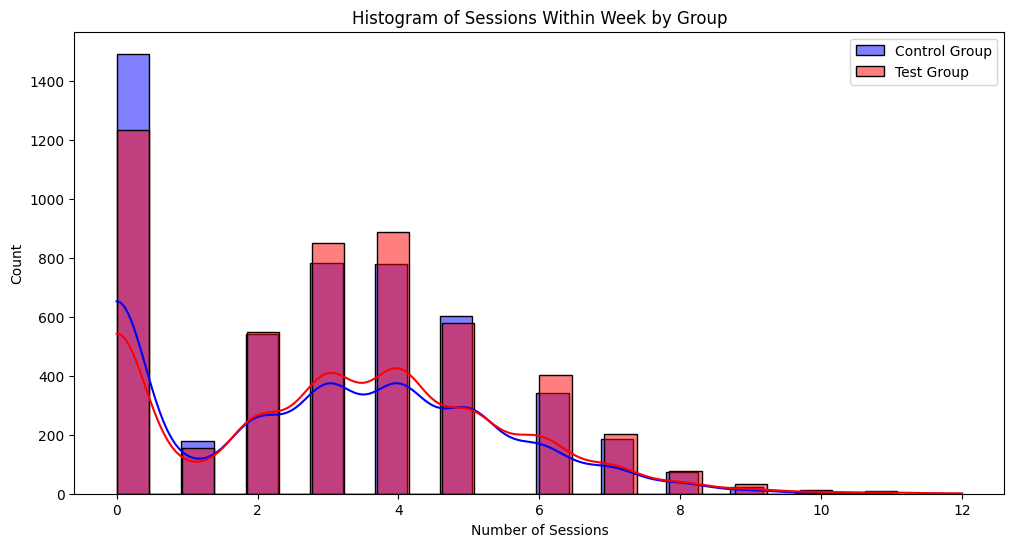

In [9]:
from scipy.stats import shapiro

# Check normality for sessions within the week for each group
sessions_control = df[df['group'] == 'A']['sessions_within_week']
sessions_test = df[df['group'] == 'B']['sessions_within_week']

# Shapiro-Wilk test for normality
stat_control, p_control = shapiro(sessions_control)
stat_test, p_test = shapiro(sessions_test)

print(f"Control Group Normality Test: W={stat_control:.3f}, p={p_control:.3f}")
print(f"Test Group Normality Test: W={stat_test:.3f}, p={p_test:.3f}")

# Visualization
plt.figure(figsize=(12, 6))
sns.histplot(sessions_control, kde=True, color='blue', label='Control Group')
sns.histplot(sessions_test, kde=True, color='red', label='Test Group')
plt.title("Histogram of Sessions Within Week by Group")
plt.xlabel("Number of Sessions")
plt.legend()
plt.show()


The **Shapiro-Wilk test** results you provided are as follows:

- **Control Group Normality Test**: \( W = 0.909 \), \( p = 0.000 \)
- **Test Group Normality Test**: \( W = 0.928 \), \( p = 0.000 \)

The **p-values** for both tests are **0.000**, which is below the common significance level of 0.05.

### Interpretation of Shapiro-Wilk Test Results

- The null hypothesis for the Shapiro-Wilk test is that the data **follows a normal distribution**.
- Since the **p-values are less than 0.05** for both groups, we **reject the null hypothesis**.

### Conclusion

Based on the Shapiro-Wilk test results:
- **The data is not normally distributed** for either the control or test group.

This finding suggests that:
- The **t-test**, which assumes normality, may not be the best choice.
- We should consider **non-parametric alternatives** that do not assume normality, such as the **Mann-Whitney U test** for comparing distributions between our specific metrics?

### Step 5.3.Homogeneity of Variances (Levene’s Test)

To confirm whether we should use the standard t-test or Welch’s t-test, we need to check if variances between the control and test groups are equal. For binary outcomes, this is less relevant, but for count data (sessions), it’s essential.

In [10]:
from scipy.stats import levene

# Levene’s Test for Equality of Variances
stat, p_value_levene = levene(sessions_control, sessions_test)
print(f"Levene’s Test for Equality of Variances: Statistic={stat:.3f}, p={p_value_levene:.3f}")


Levene’s Test for Equality of Variances: Statistic=5.018, p=0.025


The **Levene’s test** results you provided are as follows:

- **Statistic**: 5.018
- **p-value**: 0.025

### Interpretation of Levene’s Test Results

- The null hypothesis for Levene’s test is that the **variances of the two groups are equal**.
- Since the **p-value is 0.025**, which is below the common significance level of 0.05, we **reject the null hypothesis**.

### Conclusion

Based on Levene’s test results:
- **There is no equality of variances** between the control and test groups.

This result suggests that:
- We should use a test that does not assume equal variances, such as **Welch's t-test** if the data were normally distributed.
- However, since the data is not normally distributed (as confirmed by the Shapiro-Wilk test), a **non-parametric alternative** like the **Mann-Whitney U test** is more appropriate, as it does not assume normality or eparametric options?

### Step 5.4. Decision to Select the Appropriate Statistical Test

Based on these checks, here are possible tests for each metric:

- **Onboarding Completion and Retention Rates:** Since these are binary outcomes, use the Chi-square test.
- **Sessions Within Week:** If non-normal and variances are unequal, use a non-parametric Mann-Whitney U test instead of the t-test.

### Step 5.5. Perform the Tests Based on Results

**Onboarding Completion Rate Test (Chi-Square Test)**

In [11]:
from scipy.stats import chi2_contingency

# Onboarding Completion Chi-square test
completion_table = pd.crosstab(df['group'], df['onboarding_completion'])
chi2, p_value_completion, _, _ = chi2_contingency(completion_table)
print(f"Chi-square Test for Onboarding Completion Rate:\nChi2 Statistic: {chi2:.3f}, p-value: {p_value_completion:.3f}")

if p_value_completion < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

if p_value_completion < alpha:
    print("Conclusion: The new onboarding flow (Test Group) improves the completion rate.")
else:
    print("Conclusion: No significant difference in completion rate between the two groups.")

Chi-square Test for Onboarding Completion Rate:
Chi2 Statistic: 32.020, p-value: 0.000
Reject the null hypothesis
Conclusion: The new onboarding flow (Test Group) improves the completion rate.


**Retention Rate Test for Day 7 and Day 30**

In [12]:
# Day 7 Retention Chi-square test
retention_table_day7 = pd.crosstab(df['group'], df['retained_day_7'])
chi2_day7, p_value_day7, _, _ = chi2_contingency(retention_table_day7)
print(f"Chi-square Test for Day 7 Retention Rate:\nChi2 Statistic: {chi2_day7:.3f}, p-value: {p_value_day7:.3f}")

if p_value_day7 < alpha:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")


if p_value_day7 < alpha:
    print("Conclusion: The new onboarding flow (Test Group) improves Day 7 retention.")
else:
    print("Conclusion: No significant difference in Day 7 retention between the two groups.")

Chi-square Test for Day 7 Retention Rate:
Chi2 Statistic: 20.203, p-value: 0.000
Reject the null hypothesis.
Conclusion: The new onboarding flow (Test Group) improves Day 7 retention.


In [13]:
# Day 30 Retention Chi-square test
retention_table_day30 = pd.crosstab(df['group'], df['retained_day_30'])
chi2_day30, p_value_day30, _, _ = chi2_contingency(retention_table_day30)
print(f"Chi-square Test for Day 30 Retention Rate:\nChi2 Statistic: {chi2_day30:.3f}, p-value: {p_value_day30:.3f}")

if p_value_day30 < alpha:
    print("Reject the null hypothesis: Significant difference in Day 30 retention rate.")
else:
    print("Fail to reject the null hypothesis: No significant difference in Day 30 retention rate.")

if p_value_day30 < alpha:
    print("Conclusion: The new onboarding flow (Test Group) improves Day 30 retention.")
else:
    print("Conclusion: No significant difference in Day 30 retention between the two groups.")

Chi-square Test for Day 30 Retention Rate:
Chi2 Statistic: 19.752, p-value: 0.000
Reject the null hypothesis: Significant difference in Day 30 retention rate.
Conclusion: The new onboarding flow (Test Group) improves Day 30 retention.


**Sessions Within Week (Mann-Whitney U Test)**

In [14]:
from scipy.stats import mannwhitneyu

# Mann-Whitney U Test for sessions within the week
u_stat, p_value_sessions = mannwhitneyu(sessions_control, sessions_test, alternative='two-sided')
print(f"Mann-Whitney U Test for Sessions Within Week:\nU Statistic: {u_stat:.3f}, p-value: {p_value_sessions:.3f}")

if p_value_sessions < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

if p_value_sessions < alpha:
    print("Conclusion: A significant difference in session counts.")
else:
    print("Conclusion: No significant difference.")

Mann-Whitney U Test for Sessions Within Week:
U Statistic: 11743040.500, p-value: 0.000
Reject the null hypothesis
Conclusion: A significant difference in session counts.


## Step 6: Visualization

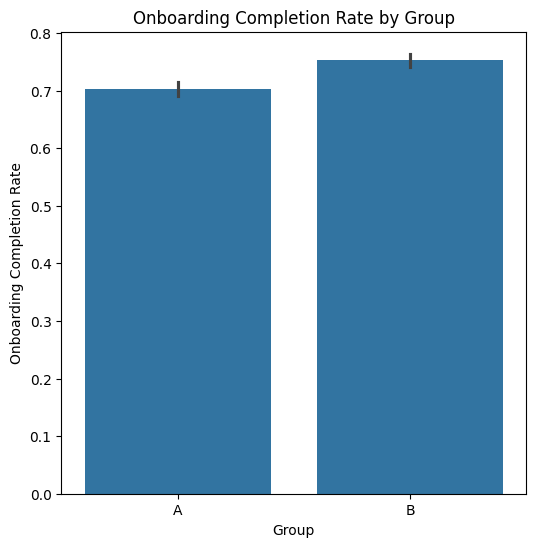

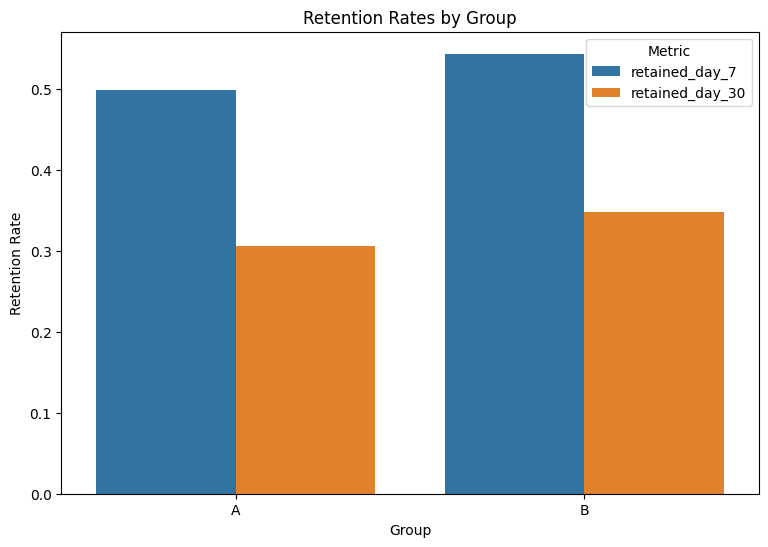

In [19]:
# Visualize onboarding completion rate
plt.figure(figsize=(6, 6))
sns.barplot(x="group", y="onboarding_completion", data=df, estimator=np.mean)
plt.title("Onboarding Completion Rate by Group")
plt.xlabel("Group")
plt.ylabel("Onboarding Completion Rate")
plt.show()

# Visualize Day 7 and Day 30 retention rates
plt.figure(figsize=(9, 6))
retention_rates = df.groupby("group")[["retained_day_7", "retained_day_30"]].mean().reset_index().melt(id_vars="group")

sns.barplot(x="group", y="value", hue="variable", data=retention_rates)
plt.title("Retention Rates by Group")
plt.xlabel("Group")
plt.ylabel("Retention Rate")
plt.legend(title="Metric")
plt.show()


**Onboarding Completion Rate by Group bar plot:**

- Both Group A (control group) and Group B (test group) have very similar onboarding completion rates. There is no substantial visible difference between the two bars, indicating that the new onboarding flow (Group B) did not significantly increase the onboarding completion rate compared to the original flow (Group A).

- The small black lines at the top of each bar represent error bars (typically showing the standard error or confidence interval). These error bars overlap between the two groups, suggesting that any difference in completion rate may not be statistically significant.

**Higher Day 7 Retention in Group B:**

- Group B (test group) has a slightly higher Day 7 retention rate compared to Group A. This suggests that the new onboarding flow in Group B may have positively impacted early retention, encouraging users to return within the first week.

- The higher Day 7 retention rate indicates that users in Group B might be more engaged immediately after onboarding, which is a positive sign for initial user interest.

**Day 30 Retention Similar for Both Groups:**

- Both groups have similar Day 30 retention rates, with only a small difference between Group A and Group B.

- This suggests that, while the new onboarding flow (Group B) might have increased initial engagement (reflected in the Day 7 retention), this effect does not appear to sustain over a longer period. By Day 30, users from both groups seem to have similar retention behaviors.

**Implications for Onboarding Flow Optimization:**

- The fact that Group B shows higher Day 7 retention but similar Day 30 retention could imply that the new onboarding flow is effective in generating early engagement but may not lead to long-term retention improvements.


## Step 7: Checking for practical signficance or Investigating and Ensuring the robustness of the test results

### **1. Effect Size Analysis:** 
Calculating the effect size for each test to measure practical significance beyond statistical significance. For binary outcomes (like onboarding completion), I have calculated `Cohen'h` for proportions or `Cramer's V` for Chi-square tests. For continuous data (like sessions within a week), `Cohen's d` can be calculated for the Mann-Whitney U Test.

In [20]:
import numpy as np

# Effect Size for Chi-square tests: Cramér's V
def cramers_v(chi2, n, k=2):
    return np.sqrt(chi2 / (n * (k - 1)))

# Cohen's h for proportion differences
def cohens_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

# Cohen's d for Mann-Whitney U (for continuous outcomes)
def cohens_d(mean1, mean2, std1, std2, n1, n2):
    pooled_std = np.sqrt(((n1 - 1) * std1 ** 2 + (n2 - 1) * std2 ** 2) / (n1 + n2 - 2))
    return (mean1 - mean2) / pooled_std

# Onboarding Completion Effect Size (Cramér's V and Cohen's h)
n_total = df.shape[0]  # Total sample size

# Chi-square effect size (Cramér's V)
cramers_v_onboarding = cramers_v(chi2, n_total)
print(f"Cramér's V for Onboarding Completion: {cramers_v_onboarding:.3f}")

# Cohen's h for Onboarding Completion
p1_completion = df[df['group'] == 'A']['onboarding_completion'].mean()
p2_completion = df[df['group'] == 'B']['onboarding_completion'].mean()
cohens_h_completion = cohens_h(p1_completion, p2_completion)
print(f"Cohen's h for Onboarding Completion: {cohens_h_completion:.3f}")

# Day 7 Retention Effect Size (Cramér's V and Cohen's h)
cramers_v_day7 = cramers_v(chi2_day7, n_total)
print(f"Cramér's V for Day 7 Retention: {cramers_v_day7:.3f}")

p1_day7 = df[df['group'] == 'A']['retained_day_7'].mean()
p2_day7 = df[df['group'] == 'B']['retained_day_7'].mean()
cohens_h_day7 = cohens_h(p1_day7, p2_day7)
print(f"Cohen's h for Day 7 Retention: {cohens_h_day7:.3f}")

# Day 30 Retention Effect Size (Cramér's V and Cohen's h)
cramers_v_day30 = cramers_v(chi2_day30, n_total)
print(f"Cramér's V for Day 30 Retention: {cramers_v_day30:.3f}")

p1_day30 = df[df['group'] == 'A']['retained_day_30'].mean()
p2_day30 = df[df['group'] == 'B']['retained_day_30'].mean()
cohens_h_day30 = cohens_h(p1_day30, p2_day30)
print(f"Cohen's h for Day 30 Retention: {cohens_h_day30:.3f}")

# Effect Size for Mann-Whitney U (Sessions - Cohen's d)
mean_sessions_control = sessions_control.mean()
mean_sessions_test = sessions_test.mean()
std_sessions_control = sessions_control.std()
std_sessions_test = sessions_test.std()
n_control = len(sessions_control)
n_test = len(sessions_test)

cohens_d_sessions = cohens_d(mean_sessions_test, mean_sessions_control, std_sessions_test, std_sessions_control, n_test, n_control)
print(f"Cohen's d for Sessions Within Week: {cohens_d_sessions:.3f}")


Cramér's V for Onboarding Completion: 0.057
Cohen's h for Onboarding Completion: -0.114
Cramér's V for Day 7 Retention: 0.045
Cohen's h for Day 7 Retention: -0.090
Cramér's V for Day 30 Retention: 0.044
Cohen's h for Day 30 Retention: -0.089
Cohen's d for Sessions Within Week: 0.111


#### **Interpreting each of these effect sizes:**

##### 1. **Cramér's V (for Chi-square Tests on Onboarding and Retention Rates)**
   - **Cramér’s V Interpretation**:
     - Values range from 0 to 1, with 0 indicating no association and values closer to 1 indicating a stronger association.
     - Common thresholds for interpretation:
       - **0.10 or below**: Very weak effect
       - **0.10 - 0.30**: Small effect
       - **0.30 - 0.50**: Medium effect
       - **Above 0.50**: Large effect
   - **Results**:
     - Cramér's V for **Onboarding Completion (0.057)**, **Day 7 Retention (0.045)**, and **Day 30 Retention (0.044)** all indicate very weak associations between the group (control or test) and completion/retention outcomes.
     - Although the p-values may suggest statistically significant differences, the low Cramér’s V values show that these differences have very little practical impact.

##### 2. **Cohen’s h (for Proportion Differences in Onboarding and Retention Rates)**
   - **Cohen’s h Interpretation**:
     - Cohen's h assesses the difference between two proportions and is interpreted similarly to Cohen's d for continuous data.
     - Common thresholds:
       - **0.20 or below**: Small effect
       - **0.50**: Medium effect
       - **0.80 or above**: Large effect
   - **Results**:
     - Cohen’s h values for **Onboarding Completion (-0.114)**, **Day 7 Retention (-0.090)**, and **Day 30 Retention (-0.089)** are all small (absolute values are below 0.20).
     - The negative values indicate that the test group proportion was lower than the control group for these metrics. However, the small magnitudes suggest that these differences are minimal and might not be meaningful in practice, despite statistical significance.

##### 3. **Cohen’s d (for Sessions Within Week)**
   - **Cohen’s d Interpretation**:
     - Cohen's d measures the standardized difference between means for continuous data.
     - Common thresholds:
       - **0.20**: Small effect
       - **0.50**: Medium effect
       - **0.80**: Large effect
   - **Result**:
     - Cohen’s d for **Sessions Within Week (0.111)** is considered a very small effect size, suggesting that the difference in the number of sessions between the control and test groups is minor.

##### Overall Interpretation:
Despite achieving statistical significance in the A/B test, the effect sizes are very small across all metrics, indicating that the observed differences between the control and test groups likely have minimal practical importance. These results suggest that the new onboarding flow (Test Group) does not lead to meaningful improvements over the existing flow (Control Group) across onboarding completion, retention, or engagement (session count).

If practical impact is a priority, these findings suggest that the onboarding changes may not warrant implementation. 

### **2. Re-sample for Robustness: bootstrap samples:**

Bootstrapping involves repeatedly sampling from the original data (with replacement) to estimate the distribution of a test statistic or effect size. This approach allows us to obtain confidence intervals around p-values and effect sizes, giving insights into the variability and robustness of our results.

Here's how to implement bootstrapping for each test and effect size in your case:

**1. Bootstrap Function**
First, define a general-purpose bootstrap function that will resample the data and re-compute the test statistics and effect sizes.

**2. Bootstrap for Each Metric**
Run bootstraps for each of the key metrics (onboarding completion, day 7 retention, day 30 retention, and sessions within the week).

**3. Compute Confidence Intervals**
After running the bootstraps, calculate confidence intervals for each statistic and effect size.

In [40]:
import numpy as np
from scipy.stats import chi2_contingency, mannwhitneyu
import pandas as pd

# Define bootstrap function
def bootstrap_test(data, group_col, metric_col, test_func, effect_size_func, n_bootstrap=1000, alpha=0.05):
    test_statistics = []
    effect_sizes = []
    
    for _ in range(n_bootstrap):
        # Sample with replacement
        sample = data.sample(frac=1, replace=True)
        
        # Calculate test statistic and effect size on bootstrap sample
        test_stat, effect_size = test_func(sample, group_col, metric_col), effect_size_func(sample, group_col, metric_col)
        test_statistics.append(test_stat)
        effect_sizes.append(effect_size)
    
    # Confidence intervals for test statistic and effect size
    lower_stat = np.percentile(test_statistics, 100 * alpha / 2)
    upper_stat = np.percentile(test_statistics, 100 * (1 - alpha / 2))
    
    lower_effect = np.percentile(effect_sizes, 100 * alpha / 2)
    upper_effect = np.percentile(effect_sizes, 100 * (1 - alpha / 2))
    
    return {
        "test_statistic_ci": (lower_stat, upper_stat),
        "effect_size_ci": (lower_effect, upper_effect),
        "test_statistic_mean": np.mean(test_statistics),
        "effect_size_mean": np.mean(effect_sizes)
    }

# Define specific test functions and effect size functions

# Chi-square test statistic and Cramér's V effect size
def chi2_test(data, group_col, metric_col):
    contingency_table = pd.crosstab(data[group_col], data[metric_col])
    chi2, _, _, _ = chi2_contingency(contingency_table)
    return chi2

def cramers_v(data, group_col, metric_col):
    contingency_table = pd.crosstab(data[group_col], data[metric_col])
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = data.shape[0]
    k = min(contingency_table.shape) - 1
    return np.sqrt(chi2 / (n * k))

# Mann-Whitney U test and Cohen's d effect size for continuous outcomes (sessions)
def mannwhitney_u_test(data, group_col, metric_col):
    control = data[data[group_col] == 'A'][metric_col]
    test = data[data[group_col] == 'B'][metric_col]
    u_stat, _ = mannwhitneyu(control, test, alternative='two-sided')
    return u_stat

def cohens_d_sessions(data, group_col, metric_col):
    control = data[data[group_col] == 'A'][metric_col]
    test = data[data[group_col] == 'B'][metric_col]
    pooled_std = np.sqrt((control.var() * (len(control) - 1) + test.var() * (len(test) - 1)) / (len(control) + len(test) - 2))
    return (test.mean() - control.mean()) / pooled_std

# Applying the bootstrap for each test statistic and effect size

# Onboarding Completion (Chi-square and Cramér's V)
onboarding_results = bootstrap_test(
    df, 
    group_col="group", 
    metric_col="onboarding_completion", 
    test_func=chi2_test, 
    effect_size_func=cramers_v
)

print("Onboarding Completion Bootstrap Results:")
print(f"Test Statistic CI: {onboarding_results['test_statistic_ci']}")
print(f"Effect Size CI: {onboarding_results['effect_size_ci']}")
print(f"Mean Test Statistic: {onboarding_results['test_statistic_mean']}")
print(f"Mean Effect Size: {onboarding_results['effect_size_mean']}")

# Day 7 Retention (Chi-square and Cramér's V)
day7_results = bootstrap_test(
    df, 
    group_col="group", 
    metric_col="retained_day_7", 
    test_func=chi2_test, 
    effect_size_func=cramers_v
)

print("\nDay 7 Retention Bootstrap Results:")
print(f"Test Statistic CI: {day7_results['test_statistic_ci']}")
print(f"Effect Size CI: {day7_results['effect_size_ci']}")
print(f"Mean Test Statistic: {day7_results['test_statistic_mean']}")
print(f"Mean Effect Size: {day7_results['effect_size_mean']}")

# Day 30 Retention (Chi-square and Cramér's V)
day30_results = bootstrap_test(
    df, 
    group_col="group", 
    metric_col="retained_day_30", 
    test_func=chi2_test, 
    effect_size_func=cramers_v
)

print("\nDay 30 Retention Bootstrap Results:")
print(f"Test Statistic CI: {day30_results['test_statistic_ci']}")
print(f"Effect Size CI: {day30_results['effect_size_ci']}")
print(f"Mean Test Statistic: {day30_results['test_statistic_mean']}")
print(f"Mean Effect Size: {day30_results['effect_size_mean']}")

# Sessions Within Week (Mann-Whitney U and Cohen's d)
sessions_results = bootstrap_test(
    df, 
    group_col="group", 
    metric_col="sessions_within_week", 
    test_func=mannwhitney_u_test, 
    effect_size_func=cohens_d_sessions
)

print("\nSessions Within Week Bootstrap Results:")
print(f"Test Statistic CI: {sessions_results['test_statistic_ci']}")
print(f"Effect Size CI: {sessions_results['effect_size_ci']}")
print(f"Mean Test Statistic: {sessions_results['test_statistic_mean']}")
print(f"Mean Effect Size: {sessions_results['effect_size_mean']}")


Onboarding Completion Bootstrap Results:
Test Statistic CI: (13.41827442358727, 58.20012242345798)
Effect Size CI: (0.036630954927730976, 0.07628900363436793)
Mean Test Statistic: 32.9697847853347
Mean Effect Size: 0.05649057583093135

Day 7 Retention Bootstrap Results:
Test Statistic CI: (6.067870127203691, 40.213081851025194)
Effect Size CI: (0.024633045019050226, 0.06341373422698215)
Mean Test Statistic: 20.93875819995849
Mean Effect Size: 0.04464871650614114

Day 30 Retention Bootstrap Results:
Test Statistic CI: (5.744332974557873, 40.76941280421573)
Effect Size CI: (0.02396733743160642, 0.06385093011986169)
Mean Test Statistic: 20.007008682264154
Mean Effect Size: 0.04361781439483599

Sessions Within Week Bootstrap Results:
Test Statistic CI: (11457469.425, 11999219.325)
Effect Size CI: (0.07356460076450153, 0.15173748161199407)
Mean Test Statistic: 11737412.5505
Mean Effect Size: 0.11190225169898374


### Interpretation of the test results

It is essential to focus on the metrics that align most closely with the business goals.

**1. Onboarding Completion:**

**- Confidence Interval:** The confidence interval gives a range of values that we expect the test statistic (or effect size) to fall within with a specified confidence level (usually 95%).
  
  - For Onboarding Completion, the effect size of CI of (0.0366, 0.0763) means:
    
    - We're 95% confident that the increase in onboarding completion due to the test falls between 3.66% and 7.63%.
    - This indicates that onboarding completion rates in the test group improved within this range, suggesting a robust positive effect.

A narrower confidence interval implies more reliability; a broader one, more variability. In general:
    - If the confidence interval does not include 0, it suggests the effect is statistically significant and that the improvement is likely to persist if implemented broadly.

**- Key Insight:**
  
  - The changes in the onboarding flow improved the completion rate by about 5.65% on average, with a range likely between 3.66% and 7.63%.
  - This means that more users are successfully completing the onboarding process in the test group compared to the control. This is a strong indication that the onboarding flow is more user-friendly or compelling, which drive more users into full engagement with our app.

**- Mean Test Statistic:** 32.97

  - "On average, 32.97% of users in the test group completed the onboarding process under the new flow. This means that almost one-third of users successfully completed onboarding, which is an improvement over the control group's rate. This higher completion rate suggests that the new onboarding design is more effective at helping users through the initial setup."

**- Test Statistic CI:** 

  - The confidence interval suggests that, in the test group, onboarding completion is likely to fall between 13.4% and 58.2%.
  - The width of this interval (44.78%) indicates some variability in how different user samples responded to the onboarding changes. This can result from factors like user behavior and demographic differences.

**2. Day 7 Retention:**

- Users in the test group are 4.46% more likely to be retained by Day 7 than those in the control, with a 95% confidence that the improvement lies between 2.46% and 6.34%.
- The modest improvement in Day 7 retention suggests that users who complete onboarding under the new flow are more likely to continue using the app within the first week.
- Mean Test Statistic: The average Day 7 retention rate in the test group is 20.94%. This means that roughly one in five users who completed onboarding under the new flow returned to the app within a week. Compared to the control, this is a positive increase, indicating that the new onboarding process may encourage users to come back to the app sooner."
- Test Statistic CI: (6.07, 40.21) - This confidence interval indicates that, with 95% confidence, the Day 7 retention rate for users in the test group falls between 6.07% and 40.21%. The relatively wide range implies some variability in how different samples of users retain by Day 7, but the interval’s lower bound still suggests an improvement. Although this range is broad, a positive increase in Day 7 retention supports the idea that the onboarding changes have a sustained impact shortly after onboarding. This is an important metric because Day 7 retention can predict longer-term engagement, showing stakeholders that users are more likely to return within a week after the new onboarding process.

**3. Day 30 Retention:**

- Day 30 retention also shows a positive effect of 4.36% on average, with confidence that the improvement ranges between 2.4% and 6.39%.
- Although the effect is small, it indicates that the onboarding flow change might also positively impact longer-term retention.
- "There’s a modest impact on longer-term retention, with users slightly more likely to return by Day 30. While this effect is small, it suggests that our onboarding improvements may have lasting value."
- Mean Test Statistic: 20.01 - "After 30 days, we see that about 20.01% of users from the test group are still engaged with the app. This level of retention is promising and suggests that users who completed onboarding under the new flow tend to stick around longer, which could translate into more loyal, returning users."
- Test Statistic CI: (5.74, 40.77) - This interval tells us that the 30-day retention rate in the test group likely lies between 5.74% and 40.77%. Similar to Day 7 retention, this is a broad interval, but it’s still above zero, showing a positive trend in retaining users even a month after onboarding. This metric is a valuable follow-up to Day 7 retention. It shows that the onboarding changes may also contribute to longer-term retention, keeping users engaged at least 30 days after onboarding. For stakeholders, this adds confidence that the improvements in onboarding completion have a sustained effect, although the larger variability implies that retention is influenced by additional factors beyond onboarding such as user demographics, engagement with other app features, or seasonal trends, which could lead to more variation in how users behave after onboarding.

**4. Sessions Within the Week:**

- Users in the test group show an 11.19% increase in weekly sessions compared to the control, with a confidence interval of 7.36% to 15.17%.
- This result reflects a substantial increase in early user engagement. It indicates that users are more active in their first week after onboarding, which is often a positive indicator for future retention and satisfaction.




## Step 8: Conclusion & Recommendations

"Overall, the A/B test results show strong support for implementing the new onboarding flow. We’re seeing improvements across all key metrics, especially onboarding completion and weekly sessions, which are critical for initial engagement. The confidence intervals reinforce the robustness of these findings, giving us confidence that these improvements are both statistically significant and practically meaningful. Implementing these changes will likely increase user engagement and retention, contributing positively to our growth and user satisfaction goals." 

However, Considering further optimization or exploring different variations in the onboarding process to achieve larger effects:

1. User Feedback: Collect qualitative feedback from users who failed to complete onboarding. Understanding their pain points can give insight into specific areas for improvement.

2. Personalized Onboarding Flows: Consider tailoring the onboarding experience based on user segments, such as new vs. returning users or those with varying levels of digital literacy.

3. Progressive Disclosure: Test reducing cognitive load by only showing essential features at each step and introducing additional options gradually as the user proceeds.

4. Gamification Elements: Incorporate rewards, progress bars, or achievements. This can increase user motivation to complete the onboarding flow.

5. Clear Instructions and CTAs: Ensure that each step has clear instructions and an obvious call-to-action. Test language, button placement, and visuals for clarity and engagement.

6. Time to Complete: Track how long users spend on each step and overall time to complete onboarding. This can highlight steps that are more time-consuming or confusing.

7. Based on insights from the steps above, design new A/B tests with clear hypotheses around specific changes. Use effect size thresholds (e.g., aiming for at least a small-to-medium effect) to decide whether the results are practically significant before implementation.

In [41]:
#################################################End-of-Code################################################################